In [81]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
from scipy import sparse
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
电子质量=9.10956*10**-31 #kg
焦耳转电子伏特=6.241509125883259e+18   #ev/j
电子电量=1.602176634*10**-19#c
圆周率=3.1415926
约化普朗克常量=6.62607015*10**-34/(2*圆周率) #j.s
约化普朗克常量ev=4.1356676969*10**-15/(2*圆周率)#ev.s
电容率=8.854187817 * 10**-12 #F/m
波尔半径=5.2917721067*10**-11  #m
batchsize=100


数量单位=100*1
观测尺度=50*1e-10
单位尺度=观测尺度/数量单位
M乘L方除h方=电子质量*单位尺度**2/约化普朗克常量ev**2 *焦耳转电子伏特



In [83]:
系数=-M乘L方除h方*电子电量**2 /(4*圆周率*电容率*观测尺度)*焦耳转电子伏特

Create a meshgrid of $x$ and $y$ coordinates

In [84]:
N = 122
P=N -1
X, Y = np.mgrid[0:P:N*1j,0:P:N*1j]
X.shape

(122, 122)

## 参考资料
[代码](https://github.com/lukepolson/youtube_channel/blob/main/Python%20GPU/schrodinger.ipynb)
[视频](https://www.youtube.com/watch?v=hxGA1Je1P-s)

照搬的 懒得翻译了

Eigenstates of the Schrodinger equation satisfy $H\psi = E\psi$ where $H$ is the Hamiltonian operator, and $E$ and $\psi$ represent the eigenvalues/eigenstates. The Hamiltonian Operator in 2D is

$$H = -\frac{1}{2m}\left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right) + V(x,y)$$

If we discretize $\psi$ into a vector (spacing $\Delta x$), the equation $H\psi = E\psi$ can be arranged and rewritten in 2 dimensions as

$$\left[-\frac{1}{2}(D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

where

* $\psi$ is a vector of length $N^2$ where $N$ is the number of discretized points in $x$ and $y$
* $D$ is an $N \times N$ matrix with -2 on the main diagonal and 1 on the two neighbouring diagonals.
* $D \oplus D$: the kronecker sum of $D$ with itself so that the derivative matrix is effectively converted to operate on a "2D" vector
* $V$ is a diagonal $N^2 \times N^2$ matrix with each entry on the diagonal representative of the potential at that particular coordinate.

 Firstly, we define our potential in units of $m \Delta x^2$; in other words `get_potential` actually returns $m\Delta x^2 V$

In [85]:
def get_potential(x, y):
    #return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
    return 系数/((x/P-0.5)**2+(y/P-0.5)**2+ 1e-10)**0.5

V = get_potential(X,Y)

Now we construct

$$- \frac{1}{2} D \oplus D + m\Delta x^2 V $$

Let $T=- \frac{1}{2} D \oplus D$ and $U = m\Delta x^2 V$

In [90]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T+U
k=10

In [91]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)
eigenvalues, eigenvectors = lobpcg(H, k=k, largest=False)
Eig=eigenvalues .detach().cpu().numpy()/M乘L方除h方

In [92]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

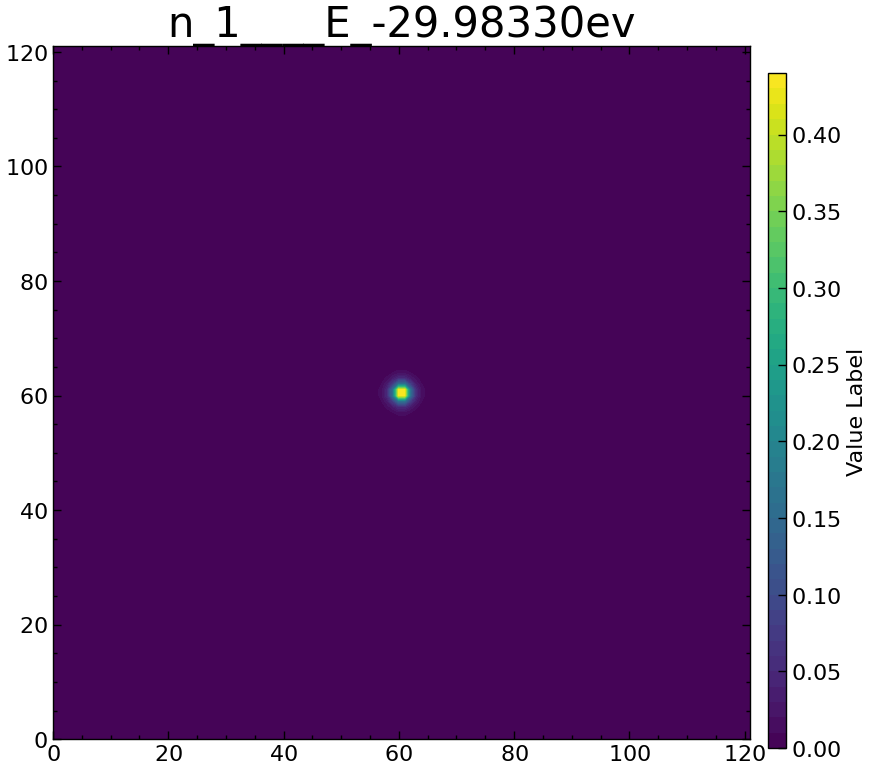

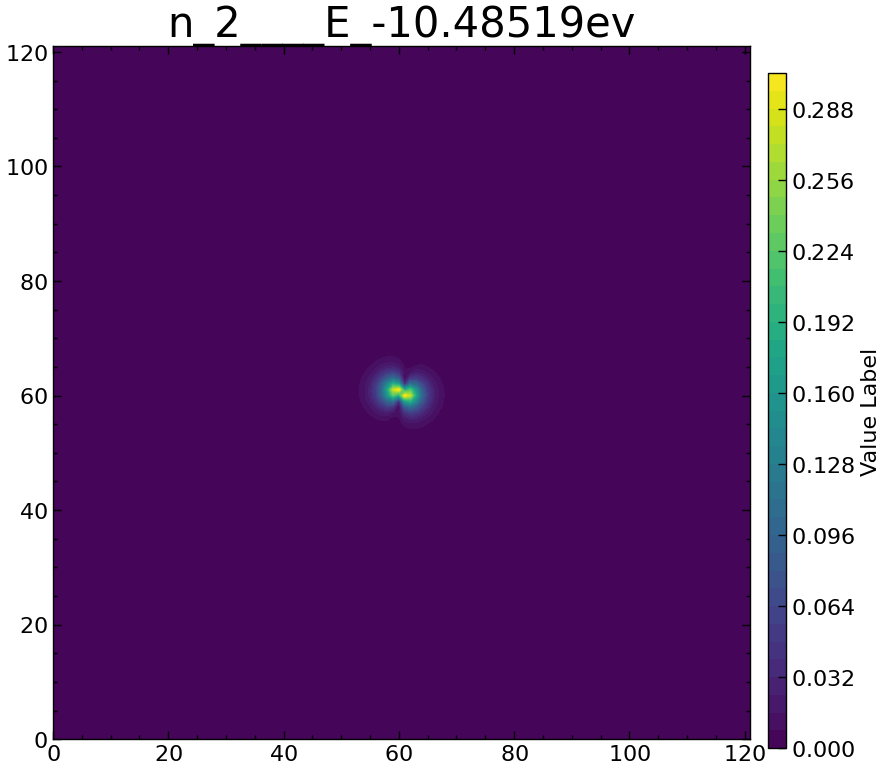

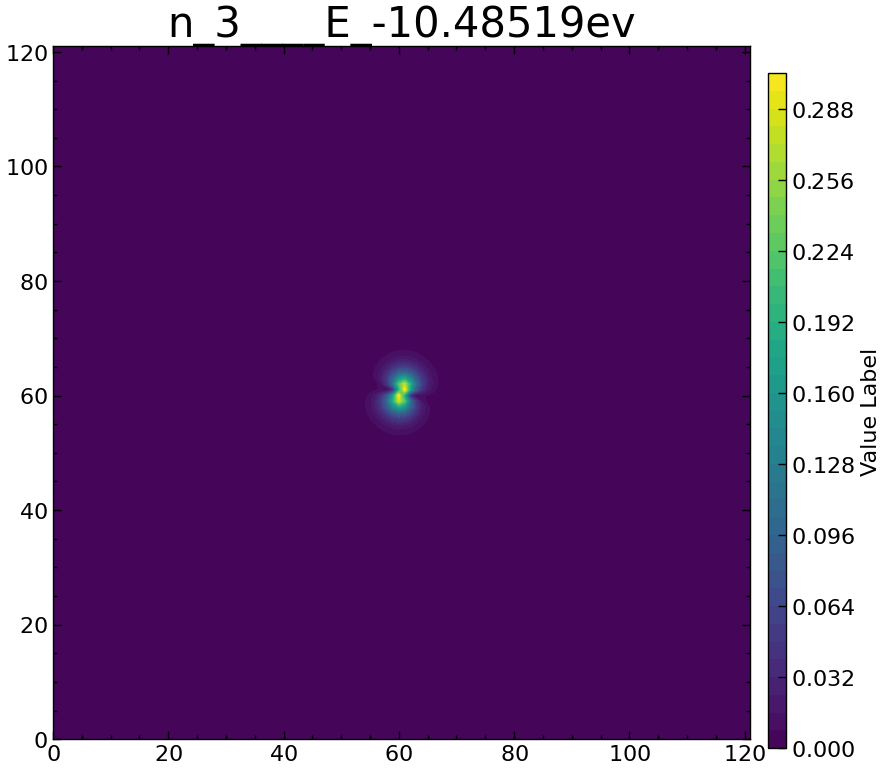

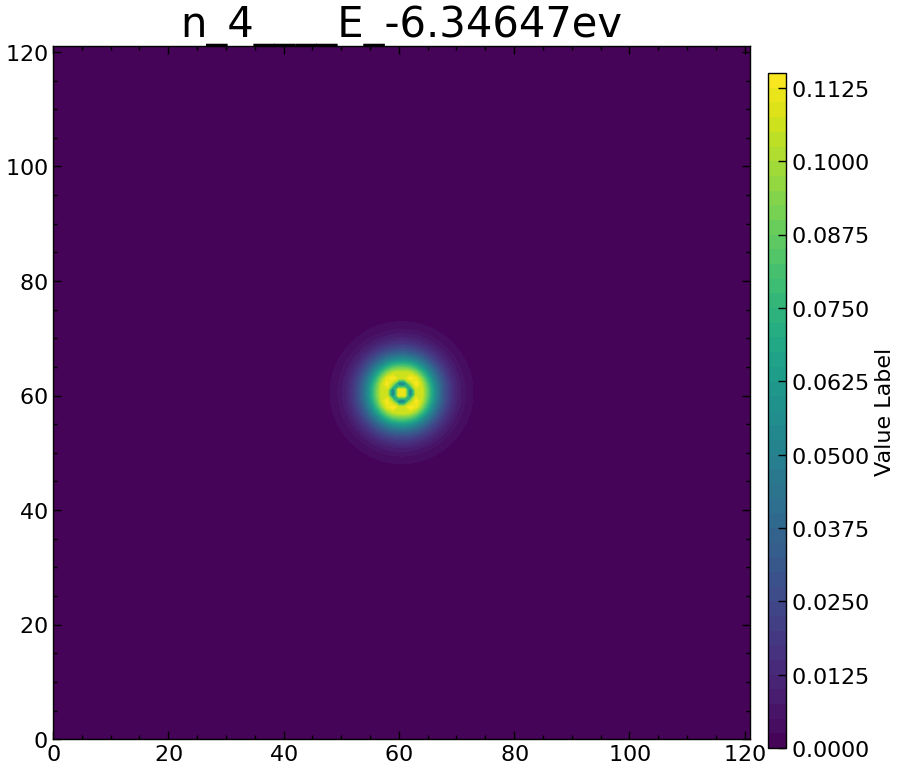

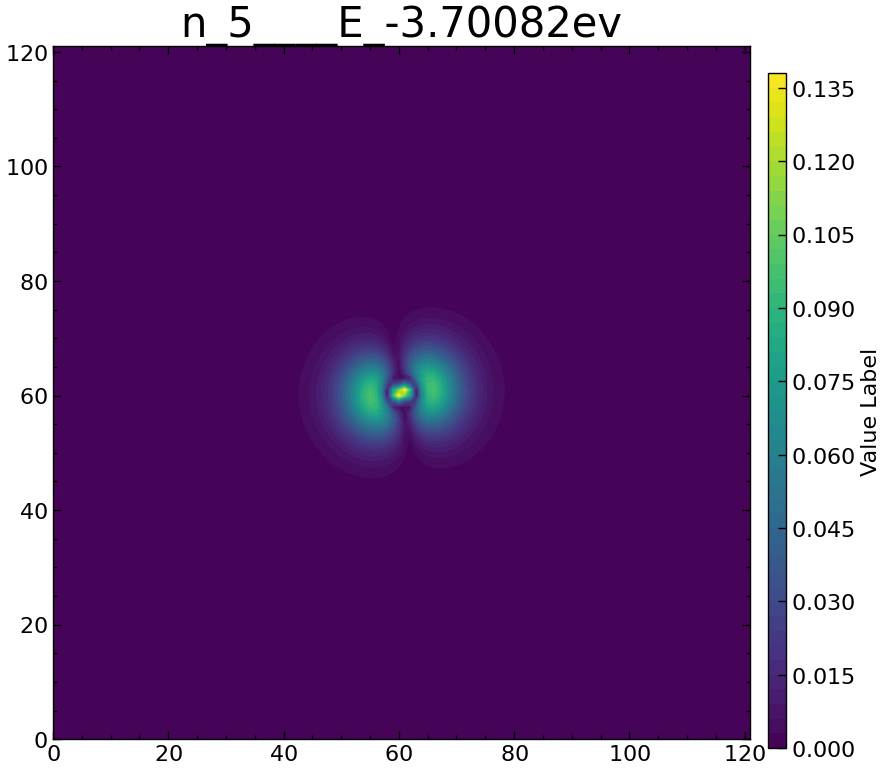

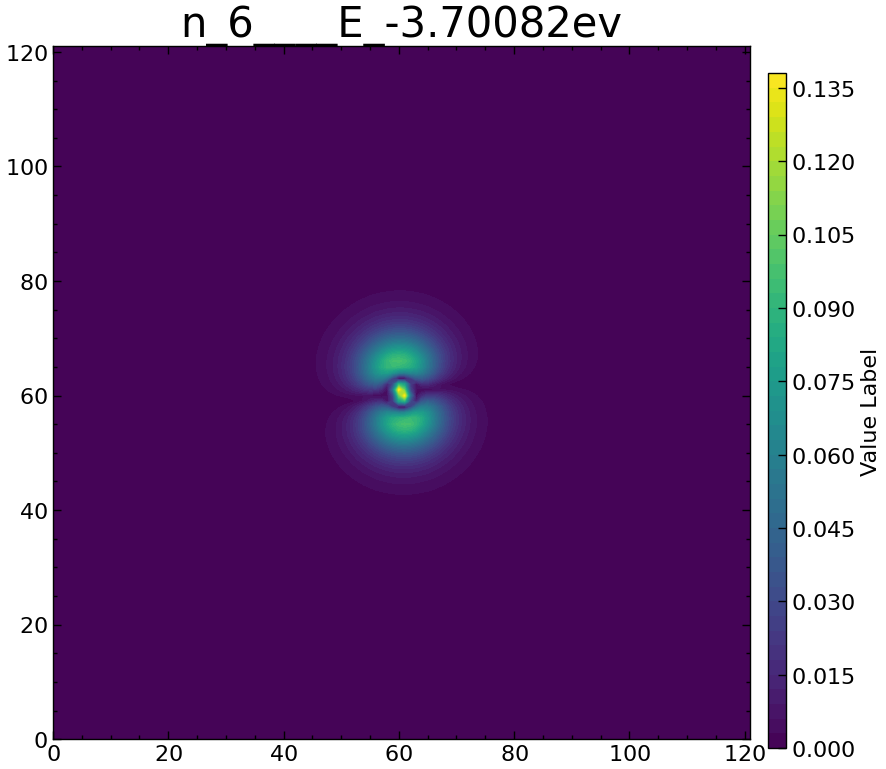

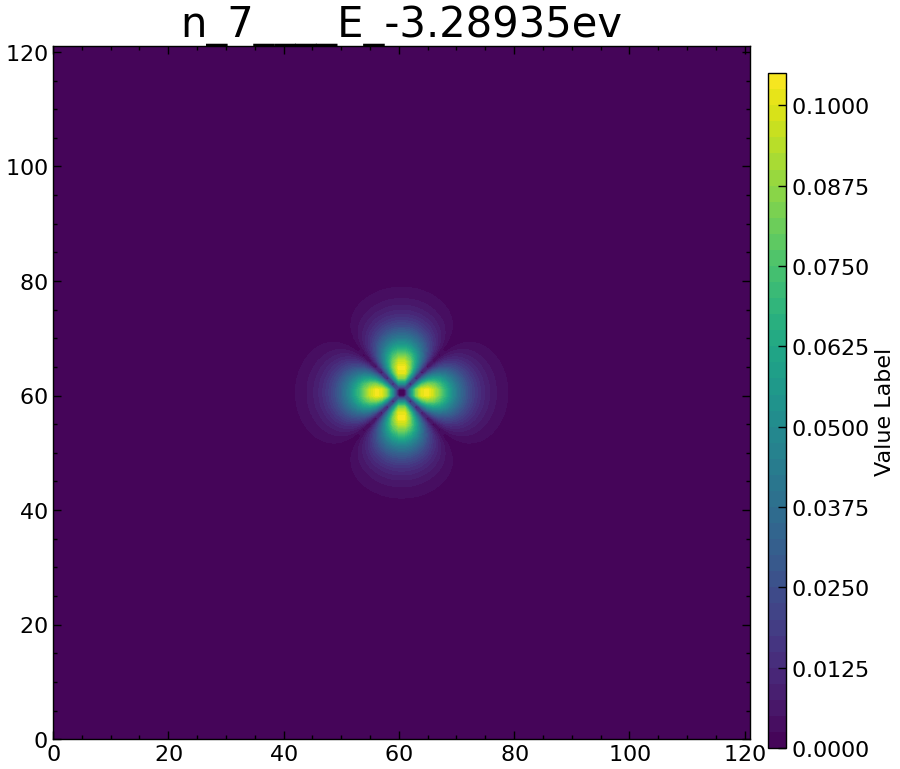

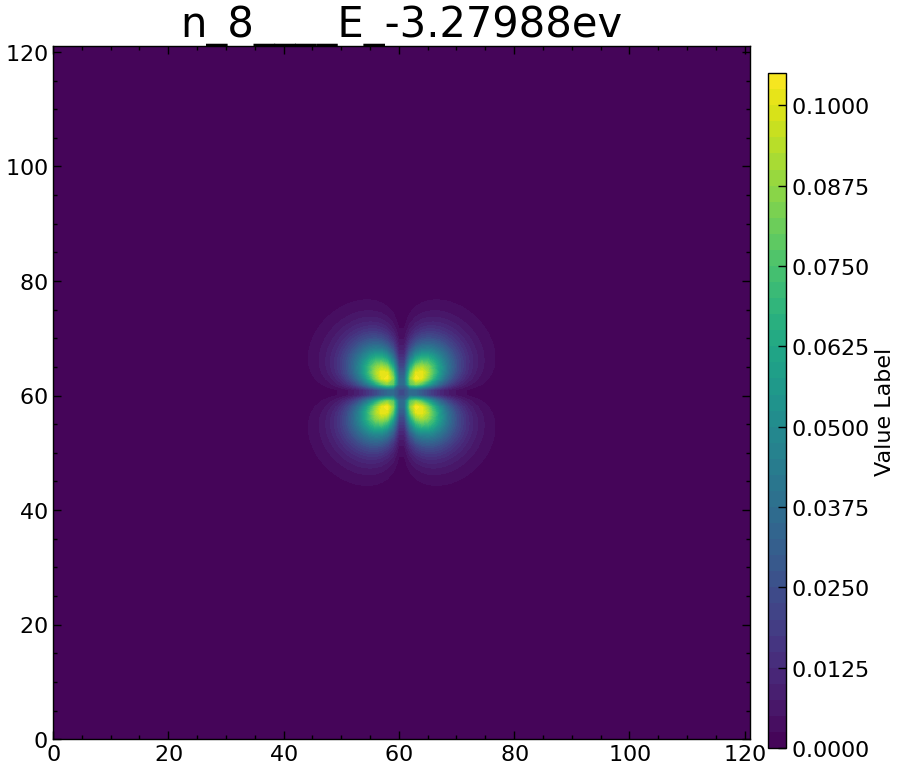

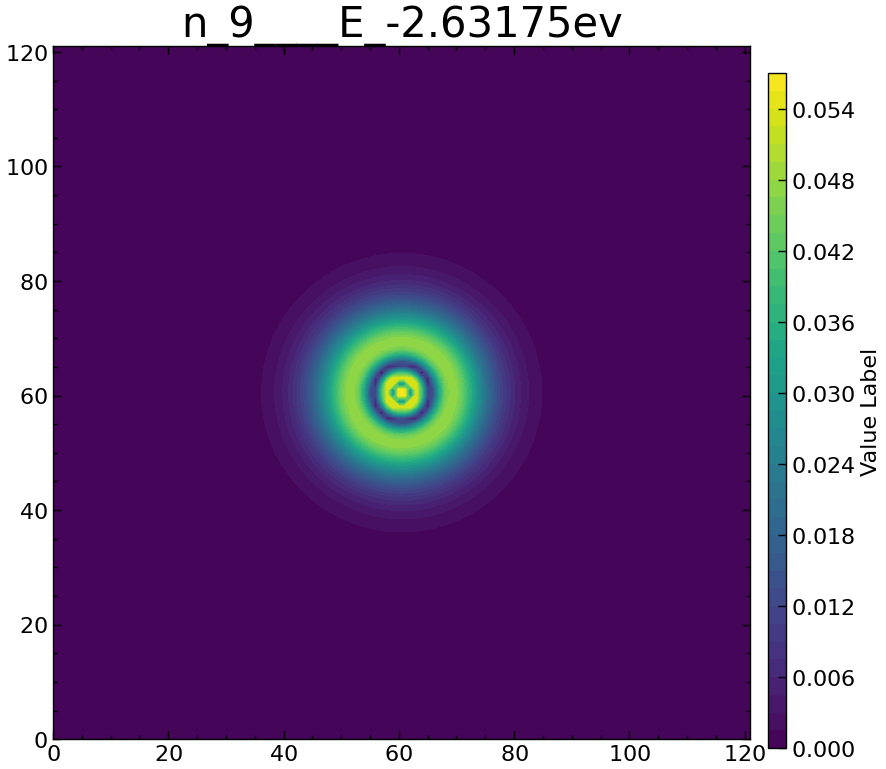

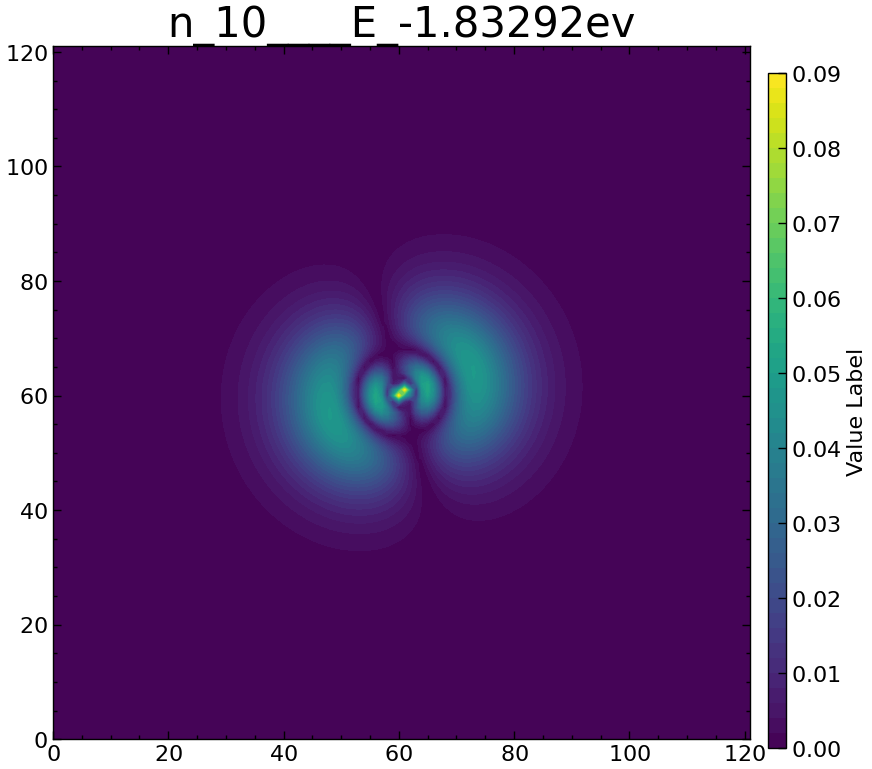

In [93]:
for i in range(k):
    plt.figure(figsize=(9, 9))

    # 绘制等高线图
    contour_data = (get_e(i)**2)**0.5
    plt.contourf(X, Y,  contour_data, 49)
    plt.title('n_{}____E_{:.5f}ev'.format(i+1,Eig[i]), fontsize=30)


    # 调整颜色条的位置和大小
    cax = plt.axes([0.92, 0.1, 0.02, 0.75])  # 调整位置和大小
    colorbar = plt.colorbar(cax=cax)
    colorbar.set_label('Value Label')
    plt.savefig('pic3/contour_plot_{:04d}.png'.format(i), bbox_inches='tight')

    plt.show()
